# Network Projections Analysis 

This Notebook shows general properties of the validated network projections

In [1]:
import pandas as pd
import numpy as np
import networkx as nx 

import matplotlib.pyplot as plt
from ast import literal_eval

from os.path import join
import os

# from token_projection.token_projection import *
# from utilities.metrics_and_tests import * 
# from utilities.utils import * 

from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('../data/snapshot_selection.csv')
df_snapshots['Date'] = pd.to_datetime(df_snapshots['Date'])  # Ensure dates are in datetime format
df_tokens = pd.read_csv("../data/final_token_selection.csv")

# Convert DataFrame to a dictionary where keys are addresses and values are symbols
address_to_symbol = pd.Series(df_tokens['symbol'].values, index=df_tokens['address']).to_dict()
address_to_symbol

# df_tokens = pd.read_csv('../assets/df_final_token_selection_20230813.csv')

# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']

### NOTE: YOU NEED TO RE-RUN TOKEN VALIDATION --> REMOVAL OF BITDAO CAUSED THIS.
### ALSO DOUBLE CHECK THAT BITDAO IS THE PROBLEM AND NOT AURA !!! 


/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [3]:
import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from src.analysis.clique_analysis import * 
from src.utilities.metrics_and_tests import jaccard_similarity
from src.visualisations.network_projections_visualisations import * 

## Visualise Network Projection of Snapshot over time

In [4]:
input_directory = os.path.join(path, 'data/validated_token_projection_graphs')
graphs, dates = load_graphs_from_snapshots(df_snapshots, input_directory)

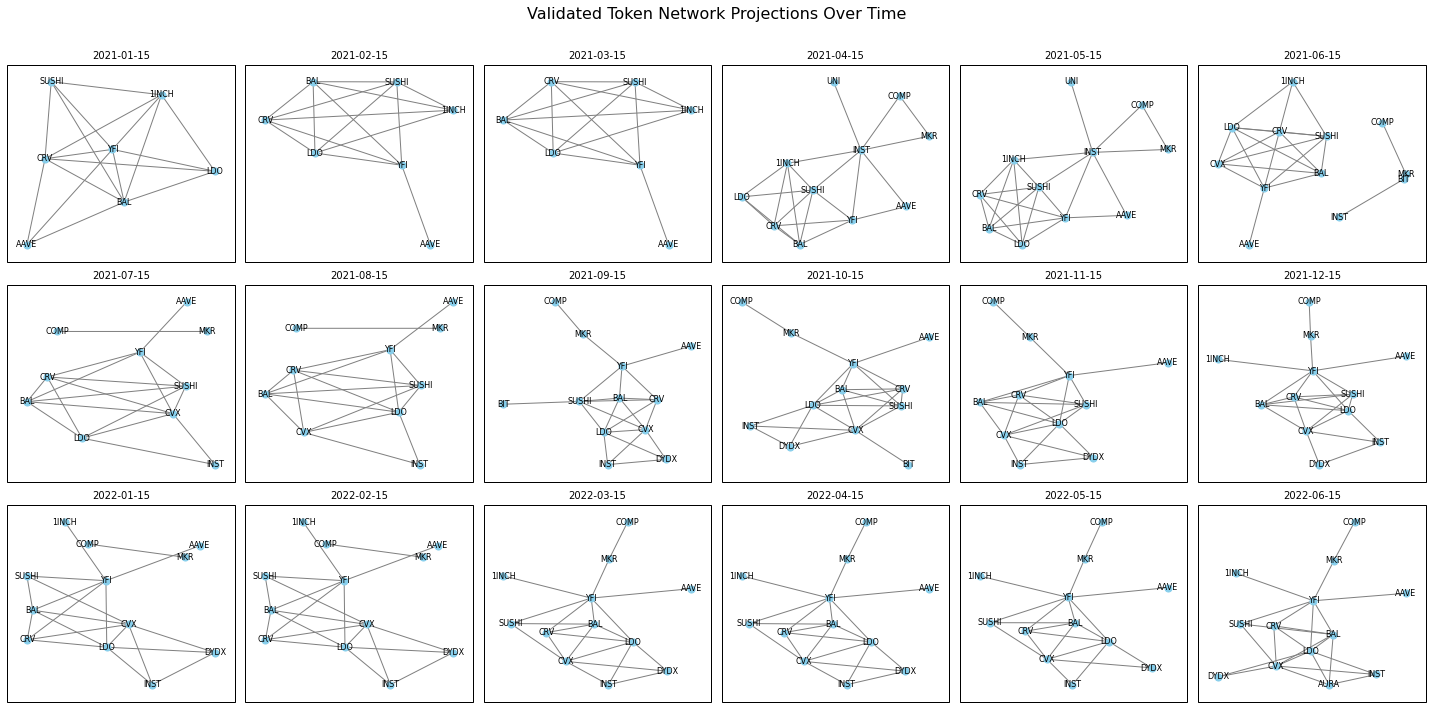

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd

def visualize_network_grid(graphs, dates, address_to_symbol, output_directory, layout=nx.kamada_kawai_layout):
    # Define the grid size
    rows, cols = 3, 6  # Adjust based on the number of graphs
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()  # Flatten to iterate easily
    
    for ax, (snapshot, graph) in zip(axes, graphs.items()):
        # Relabel nodes with symbols using the mapping
        relabeled_graph = nx.relabel_nodes(graph, address_to_symbol)
        
        # Compute layout
        pos = layout(relabeled_graph)  
        
        # Draw the graph with relabeled nodes
        nx.draw(relabeled_graph, pos, ax=ax, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray', font_size=8)
        ax.set_title(dates[snapshot], fontsize=10)
        ax.set_axis_off()  # Hide axis for clarity
        
        # Draw a rectangle around the plot area
        rect = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='black', facecolor='none', transform=ax.transAxes, clip_on=False)
        ax.add_patch(rect)

    # Turn off any unused subplots
    for i in range(len(graphs), len(axes)):
        axes[i].set_axis_off()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust the top spacing to accommodate title if necessary
    
    # Save the figure
    fig.suptitle('Validated Token Network Projections Over Time', fontsize=16)
    plt.savefig(os.path.join(output_directory, "network_projection_grid.png"), format='png', dpi=300)
    plt.show()
    
# Assuming `graphs` and `dates` are already filled from your graph loading code
visualize_network_grid(graphs, dates, address_to_symbol, output_directory='../output/network_projections/', layout=nx.kamada_kawai_layout)


## Jaccard Similarity of Validated Network Projection over time 

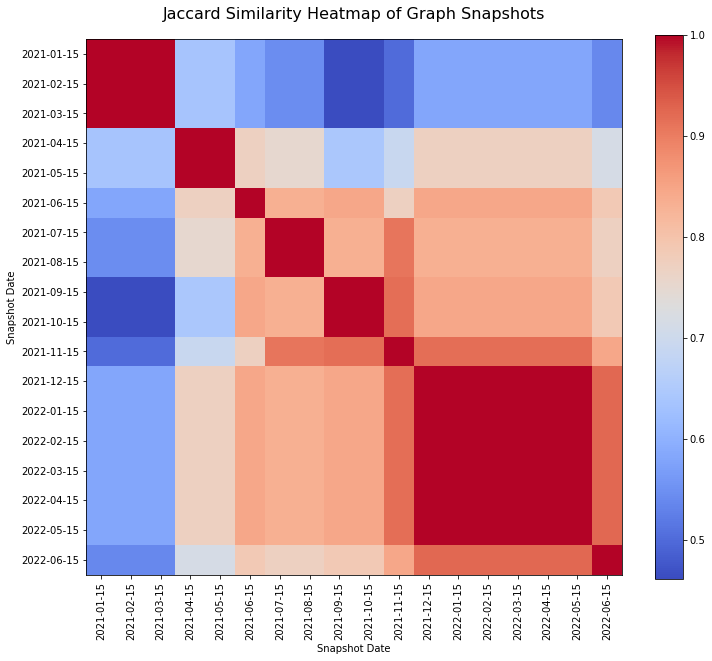

In [7]:
similarity_matrix, snapshot_list = calculate_similarity_matrix(graphs)

plot_similarity_heatmap(similarity_matrix, snapshot_list, dates, output_directory='../output/network_projections/')

In [6]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import os

# def plot_token_ownership_over_time(path, df_snapshots, df_tokens, known_burner_addresses):
#     pct_addresses_holding_given_token = []
    
#     # Filter relevant block heights
#     relevant_snapshots = df_snapshots[df_snapshots['Block Height'] >= 11659570]['Block Height']
    
#     for snapshot in relevant_snapshots:
#         # Read the snapshot
#         file_path = os.path.join(path, f"data/snapshot_token_balance_tables/token_holder_snapshot_balance_{snapshot}.csv")
#         ddf = pd.read_csv(file_path, index_col=[0])
        
#         ddf = ddf[ddf.value > 0]  # Consider non-zero balances at snapshot

#         # Calculate the total value for each token
#         total_value_per_token = ddf.groupby('token_address').value.sum()

#         # Calculate percentage of supply held
#         ddf['pct_supply'] = ddf.apply(lambda x: x['value'] / total_value_per_token[x['token_address']], axis=1)

#         # Filter to the latest tokens and exclude known burner addresses
#         ddf.reset_index(inplace=True)
#         ddf = ddf[ddf.token_address.isin(df_tokens.address)]
#         ddf = ddf[~ddf.address.isin(known_burner_addresses)]
        
#         # Calculate the fraction of addresses holding a significant amount of each token
#         fractional_ownership = ddf.groupby('token_address').address.nunique() / ddf.address.nunique()
#         pct_addresses_holding_given_token.append(fractional_ownership)

#     # Concatenate the results across all snapshots
#     df_token_fractional_ownership = pd.concat(pct_addresses_holding_given_token, axis=1, join='outer')
#     df_token_fractional_ownership.columns = list(df_snapshots[df_snapshots['Block Height'] >= 11659570]['Date'])

#     # Map token addresses to names and set as index
#     token_name_dict = dict(zip(df_tokens['address'], df_tokens['name'])) 
#     df_token_fractional_ownership['name'] = df_token_fractional_ownership.index.map(token_name_dict)
#     df_token_fractional_ownership.set_index('name', inplace=True)
    
#     # Plotting
#     ax = df_token_fractional_ownership.T.plot(kind='line', figsize=(10, 6))
#     plt.xlabel('Date')
#     plt.ylabel('Fraction of Wallets Holding')
#     plt.title('Fraction of Wallets Holding a Given Token Over Time')
#     plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.show()

# # Example usage assuming you have defined df_snapshot, df_addresses, and known_burner_addresses
# plot_token_ownership_over_time(path, df_snapshots, df_tokens, known_burner_addresses)
